# Living Intelligence Clinical Reasoning - Recovery Time Prediction
This cell initializes the fundamental Python libraries needed for the Inference Agent to process clinical data, perform exploratory analysis, and develop predictive models for assessing post-surgical complication risk. It sets up the computational environment by importing tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), model evaluation, and several regression algorithms from scikit-learn. This forms the foundation for subsequent data handling and modeling tasks in the notebook.

# Hospital LOS (Length-of-Stay)
First of all what is LOS? **Hospital length-of-stay (LOS)** is defined as the time between hospital admission and discharge measured in days.

## 1. Problem Statement

**The goal is to create a model that predicts the length-of-stay for each patient at time of admission.**

In order to predict hospital LOS, the MIMIC data needed to be separated into terms of:
- dependent target variable (length-of-stay in this case) 
- and independent variables (features) to be used as inputs to the model. 

## 2. Type of model used for prediction
Since LOS is not a categorical but continuous variable (measured in days), a **regression model** will be used for prediction. 

## 3. Metrics used for validation
The expected outcome is that the model we use will be better at predicting hospital LOS than the industry standards of **median and average LOS**. The median LOS is simply the median LOS of past admissions to a hospital. Similarly, a second commonly used metric in healthcare is the average, or mean LOS. 

So, to measure performance of our model, we'll compare the prediction model against the median and average LOS using the root-mean-square error (RMSE). The RMSE is a commonly used measure of the differences between values predicted by a model and the values observed, where a *lower score implies better accuracy*. For example, a perfect prediction model would have an RMSE of 0. 

The RMSE equation for this work is given as follows, where (n) is the number of hospital admission records, (y-hat) the prediction LOS, and (y) is the actual LOS.

<img src="data/images/RMSE.png" alt="RMSE">

We could say we have a successful model if its prediction results in a lower RMSE than the average or median models.

There is a multitude of regression models available for predicting LOS. To determine the best regression model between the subset of models that will be evaluated, the **R2 (R-squared)** score will be used.

R Square measures how much variability in dependent variable can be explained by the model. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where (y_i) is an observed data point, (ŷ) is the mean of the observed data, and (f_i) the predicted model value.

<img src="data/images/R2.png" alt="R2">

Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import torch
import os
import gzip

In [50]:
import os
data_path = './data/mimic-iv-clinical-database-demo-2.2/hosp'
# Delete all .csv files in the folder
csv_list = [f for f in os.listdir(data_path) if f.endswith('.csv')]
for csv_file in csv_list:
    csv_path = os.path.join(data_path, csv_file)
    try:
        os.remove(csv_path)
        print(f"Deleted file: {csv_file}")
    except Exception as e:
        print(f"Error deleting {csv_file}: {e}")
data_path = './data/mimic-iv-clinical-database-demo-2.2/icu'  
csv_list = [f for f in os.listdir(data_path) if f.endswith('.csv')]
for csv_file in csv_list:
    csv_path = os.path.join(data_path, csv_file)
    try:
        os.remove(csv_path)
        print(f"Deleted file: {csv_file}")
    except Exception as e:
        print(f"Error deleting {csv_file}: {e}")
data_path = './data/mimic-iv-clinical-database-demo-2.2/icu/'  

# Existing code
zip_list = [f for f in os.listdir(data_path) if f.endswith('.gz')]

for zip_file in tqdm(zip_list):
    try:
        with gzip.open(os.path.join(data_path, zip_file), 'rb') as zf:
            data = zf.read()
        with open(os.path.join(data_path, zip_file.split('.')[0] + '.csv'), 'wb') as f:
            f.write(data)
    except Exception as e:
        print(f'File error: {zip_file} - {e}')
data_path = './data/mimic-iv-clinical-database-demo-2.2/hosp/' 
zip_list = [f for f in os.listdir(data_path) if f.endswith('.gz')]

for zip_file in tqdm(zip_list):
    try:
        with gzip.open(os.path.join(data_path, zip_file), 'rb') as zf:
            data = zf.read()
        with open(os.path.join(data_path, zip_file.split('.')[0] + '.csv'), 'wb') as f:
            f.write(data)
    except Exception as e:
        print(f'File error: {zip_file} - {e}')

Deleted file: admissions.csv
Deleted file: diagnoses_icd.csv
Deleted file: drgcodes.csv
Deleted file: d_hcpcs.csv
Deleted file: d_icd_diagnoses.csv
Deleted file: d_icd_procedures.csv
Deleted file: d_labitems.csv
Deleted file: emar.csv
Deleted file: emar_detail.csv
Deleted file: hcpcsevents.csv
Deleted file: labevents.csv
Deleted file: microbiologyevents.csv
Deleted file: omr.csv
Deleted file: patients.csv
Deleted file: pharmacy.csv
Deleted file: poe.csv
Deleted file: poe_detail.csv
Deleted file: prescriptions.csv
Deleted file: procedures_icd.csv
Deleted file: provider.csv
Deleted file: services.csv
Deleted file: transfers.csv
Deleted file: caregiver.csv
Deleted file: chartevents.csv
Deleted file: datetimeevents.csv
Deleted file: d_items.csv
Deleted file: icustays.csv
Deleted file: ingredientevents.csv
Deleted file: inputevents.csv
Deleted file: outputevents.csv
Deleted file: procedureevents.csv


100%|██████████| 22/22 [00:00<00:00, 95.15it/s]


## 4. Features distribution and features engineering

We start importing our baseline dataset extracted selecting only the necessary tables from MIMIC dataset.

In [51]:

admits_patients_diag = pd.read_csv('admits_patients_diag.csv')

#convert dates
admits_patients_diag.admittime = pd.to_datetime(admits_patients_diag.admittime)
admits_patients_diag.dischtime = pd.to_datetime(admits_patients_diag.dischtime)
admits_patients_diag.deathtime = pd.to_datetime(admits_patients_diag.deathtime)

admits_patients_diag.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaT,EMERGENCY,Medicaid,0,M,...,1,2,1,3,0,0,1,0,2,0
1,1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaT,EMERGENCY,Medicaid,0,M,...,0,1,0,0,0,0,1,0,0,0
2,2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaT,EMERGENCY,Medicare,0,M,...,0,6,1,0,0,0,0,0,0,0
3,3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,EMERGENCY,Medicaid,1,M,...,0,0,1,1,0,0,0,0,0,0
4,4,10005817,20626031,2132-12-12 01:43:00,2132-12-20 15:04:00,NaT,EMERGENCY,Medicare,0,M,...,1,8,2,1,1,0,0,0,1,0


#### Length of stays computation
The LOS is not explicitly expressed as attribute in the admission table, so we have to calculate it. As we said, LOS is defined as the time between admission and discharge from the hospital.

In [52]:
# Create LOS attribute converting timedelta type into float 'days', 86400 seconds in a day
admits_patients_diag['los'] = (admits_patients_diag['dischtime'] - admits_patients_diag['admittime']).dt.total_seconds()/86400

# Verify LOS computation
admits_patients_diag[['admittime', 'dischtime', 'los']].head()

,admittime,dischtime,los
0,2196-02-24 14:38:00,2196-03-04 14:02:00,8.975000
1,2153-09-17 17:08:00,2153-09-25 13:20:00,7.841667
2,2134-08-18 02:02:00,2134-08-23 19:35:00,5.731250
3,2111-11-13 23:39:00,2111-11-15 17:20:00,1.736806
4,2132-12-12 01:43:00,2132-12-20 15:04:00,8.556250


In [53]:
# We could already have a quick insight on how LOS values are distributed
admits_patients_diag['los'].describe()

count    152.000000
mean       6.922090
std        6.742292
min        0.125000
25%        2.761458
50%        5.163542
75%        8.586979
max       44.927778
Name: los, dtype: float64

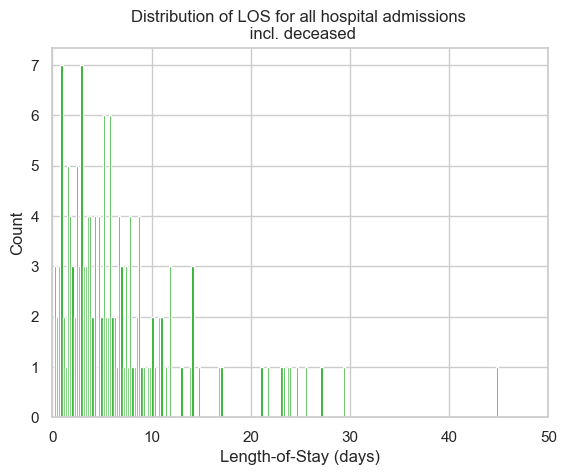

In [54]:
# Plot LOS Distribution
plt.hist(admits_patients_diag['los'], bins=200, color = '#11a612')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

Another thing to consider is admissions of patients who died at the hospital. This kind of admissions resulting in death will be excluded as they would bias the LOS since LOS would be shorter for this group (in data cleaning process this group will be dropped).

In [55]:
print("{} of {} patients died at the hospital".format(admits_patients_diag['died_at_the_hospital'].sum(), admits_patients_diag['subject_id'].nunique()))

6 of 76 patients died at the hospital


We also said that we'll use the LOS mean and median for comparison and for understand the accuracy of our model. So let's compute these LOS metrics that we'll use later for model evalutaion.

In [56]:
# Hospital LOS metrics for later comparison
actual_mean_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].mean() 
actual_median_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

6.958476027397261
5.163541666666667


#### ADMISSION_TYPE attribute

In [57]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by dataframe categorical series name 
    '''
    results = admits_patients_diag[[variable, 'los']].groupby(variable).median().reset_index()
    values = list(results['los'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();


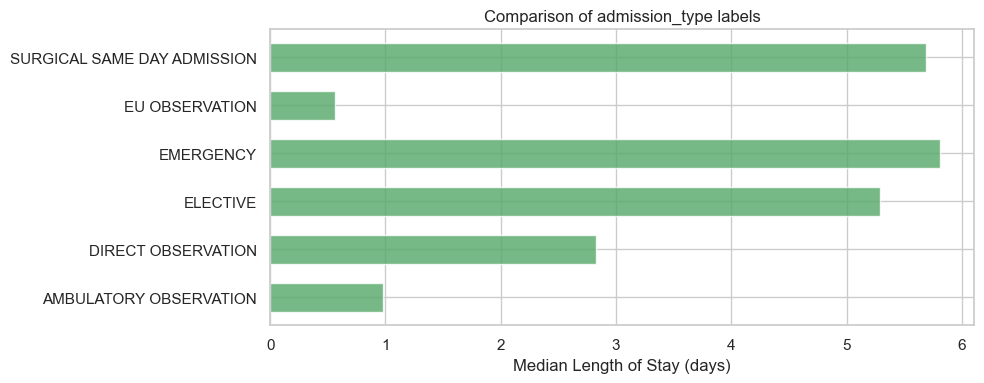

In [58]:
# Look at median LOS for groups ADMISSION_TYPE
plot_los_groupby('admission_type', size=(10,4))

As we could expected *observation* and *elective* admissions have the lowest LOS. This is expected since these are often somewhat planned for and with the risks being understood in comparison to EMERGENCY ADMISSION_TYPE.

#### AGE attribute

Now let's see how the LOS, our current goal, is correlated to ther age of the patients.

       anchor_age         los
count  152.000000  152.000000
mean    61.828947    6.922090
std     14.493559    6.742292
min     21.000000    0.125000
25%     52.750000    2.761458
50%     63.000000    5.163542
75%     72.000000    8.586979
max     91.000000   44.927778


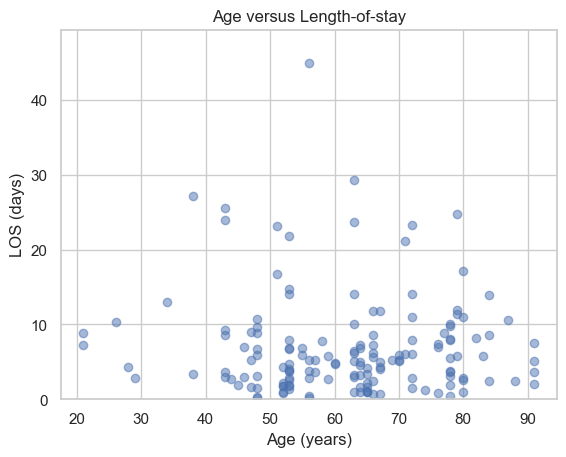

In [59]:
# Basic data check:
print(admits_patients_diag[['anchor_age', 'los']].describe())
# Plot with visible alpha and limits:
plt.scatter(admits_patients_diag['anchor_age'], admits_patients_diag['los'], alpha=0.5)
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(0, admits_patients_diag['los'].max() * 1.1)  # Dynamic y-limit
plt.show()

The plot highlights the MIMIC groups of newborns and >89 year olds have higher LOS, and there is an increasing LOS going from 20 toward 80 years old. Because of the discrete-like distribution of data on the extremes of age, it could be useful to convert all ages into the categories of **newborn, young adult, middle adult, and senior** for use in the prediction model.

In [60]:
age_ranges = [(0, 13), (14, 36), (37, 56), (57, 100)]
for num, cat_range in enumerate(age_ranges):
    admits_patients_diag['anchor_age'] = np.where(admits_patients_diag['anchor_age'].between(cat_range[0],cat_range[1]), num, admits_patients_diag['anchor_age'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
admits_patients_diag['anchor_age'] = admits_patients_diag['anchor_age'].replace(age_dict)
admits_patients_diag.anchor_age.value_counts()

anchor_age
SENIOR          91
MIDDLE_ADULT    55
YOUNG_ADULT      6
Name: count, dtype: int64

Finally, let's see the distribution of gender in patients in correlation to LOS.

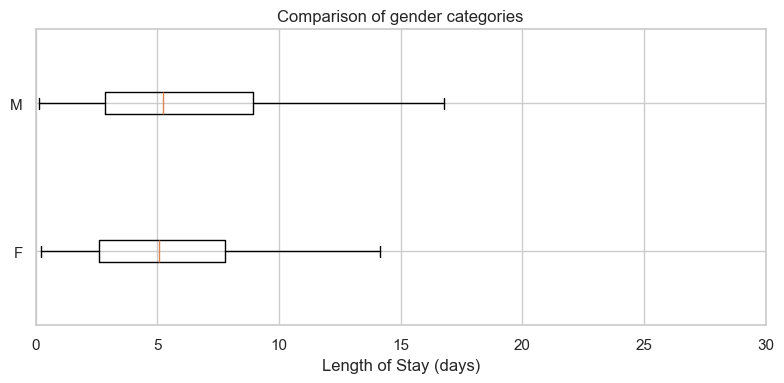

In [61]:
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = admits_patients_diag[[variable, 'los']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(admits_patients_diag['los'].loc[admits_patients_diag[variable]==cat].values)

    _, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();
boxplot_los_groupby('gender', los_range=(0, 30))

## DIAGNOSIS
Let's analyze the diagnosis in correlation to our target LOS.

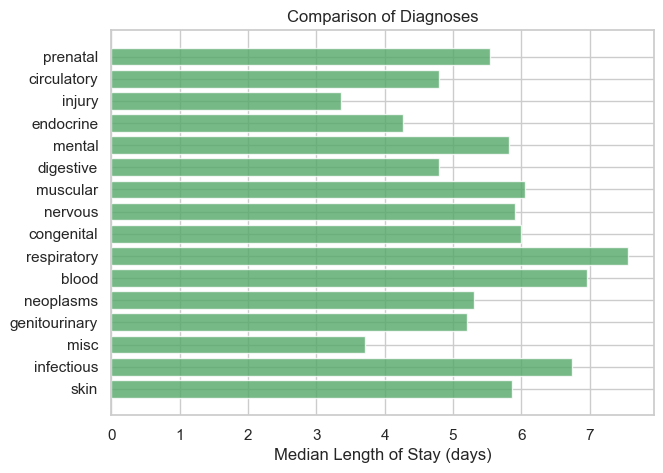

In [62]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal']

results = []
for variable in diag_cat_list:
    results.append(admits_patients_diag[[variable, 'los']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

Looking at the median LOS for each ICD-9 supercategory shows an important difference between infectuous and pregnancy code groups for example. This could already means that the patients diagnosed an *infection* usually stay longer at the hospital in comparison to other categories.

### ICUSTAYS table data extraction

The data in the ICUSTAYS table could be useful because indicates if a patient during an admission was in an ICU (Intensive Care Unit). This of course could be a factor that could increment the length of stay of patient.

In [63]:
mimic4_path = './data/mimic-iv-clinical-database-demo-2.2/'

# read icustays table
def read_icustays_table(mimic4_path):
    icustays = pd.read_csv(mimic4_path + 'icu/icustays.csv')
    return icustays

icustays = read_icustays_table(mimic4_path)
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10018328,23786647,31269608,Neuro Stepdown,Neuro Stepdown,2154-04-24 23:03:44,2154-05-02 15:55:21,7.702512
1,10020187,24104168,37509585,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown,2169-01-15 04:56:00,2169-01-20 15:47:50,5.452662
2,10020187,26842957,32554129,Neuro Intermediate,Neuro Intermediate,2170-02-24 18:18:46,2170-02-25 15:15:26,0.872685
3,10012853,27882036,31338022,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-26 02:34:49,2176-11-29 20:58:54,3.766725
4,10020740,25826145,32145159,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-03 20:12:32,2150-06-04 21:05:58,1.037106


In [64]:
numeric_cols = icustays.select_dtypes(include='number').columns
result = icustays.groupby('first_careunit')[numeric_cols].median()
result.head(20)

,subject_id,hadm_id,stay_id,los
first_careunit,,,,
Cardiac Vascular Intensive Care Unit (CVICU),10013049.0,24490144.0,35258379.0,1.999329
Coronary Care Unit (CCU),10023117.0,24181354.0,36059427.0,4.952106
Medical Intensive Care Unit (MICU),10019777.0,25260176.0,34617352.0,2.859664
Medical/Surgical Intensive Care Unit (MICU/SICU),10019003.0,25563031.0,34577403.0,2.885938
Neuro Intermediate,10020187.0,26842957.0,32554129.0,0.872685
Neuro Stepdown,10018328.0,23786647.0,31269608.0,7.702512
Neuro Surgical Intensive Care Unit (Neuro SICU),10020187.0,24540843.0,37509585.0,5.452662
Surgical Intensive Care Unit (SICU),10022041.0,24717014.0,35475449.0,1.788611
Trauma SICU (TSICU),10018081.0,25937287.0,36063159.0,2.042309


From this statistic we can see how, as far as LOS is concerned, a substantial difference in the median is found only between *Neuro SICU*, *Neuro Intermediate* and the other categories that we can call *Other-ICU*. The *Other_ICU* categories have a very similar median. We can therefore think of simply reducing the categories on three groups: *Neuro SICU*, *Neuro Intermediate* and *Other-ICU* (which includes all the others).

In [65]:
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings

# icustays['first_careunit'].replace({'Cardiac Vascular Intensive Care Unit (CVICU)': 'CVICU', 'Coronary Care Unit (CCU)': 'CCU', 'Medical Intensive Care Unit (MICU)': 'Other-ICU', 'Medical/Surgical Intensive Care Unit (MICU/SICU)': 'Other-ICU', 'Neuro Stepdown': 'NI', 'Surgical Intensive Care Unit (SICU)': 'SICU', 'Trauma SICU (TSICU)': 'Other-ICU'}, inplace=True)

icustays['category'] = icustays['first_careunit']
icu_list = icustays.groupby('hadm_id')['category'].apply(list).reset_index()
icu_list.head()

,hadm_id,category
0,20044587,[Cardiac Vascular Intensive Care Unit (CVICU)]
1,20199380,[Cardiac Vascular Intensive Care Unit (CVICU)]
2,20214994,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,20291550,[Trauma SICU (TSICU)]
4,20297618,[Cardiac Vascular Intensive Care Unit (CVICU)]


In [66]:
icustays['first_careunit'].value_counts()

first_careunit
Surgical Intensive Care Unit (SICU)                 29
Medical Intensive Care Unit (MICU)                  29
Cardiac Vascular Intensive Care Unit (CVICU)        25
Medical/Surgical Intensive Care Unit (MICU/SICU)    23
Trauma SICU (TSICU)                                 16
Coronary Care Unit (CCU)                            13
Neuro Surgical Intensive Care Unit (Neuro SICU)      3
Neuro Stepdown                                       1
Neuro Intermediate                                   1
Name: count, dtype: int64

In [67]:
# Explode 'category' column (which contains lists) to rows, stack, then get dummies
stacked = icu_list['category'].apply(pd.Series).stack()

# Get dummy variables for each ICU category
dummies = pd.get_dummies(stacked)

# Group by the original index level 0 (row index of icu_list) and sum per ICU category
icu_item = dummies.groupby(level=0).sum()

# Binarize counts: convert all counts >= 1 to 1 (indicating presence)
icu_item[icu_item >= 1] = 1

# Join the hadm_id column back to the dummies DataFrame
icu_item = icu_item.join(icu_list['hadm_id'], how='outer')

# Display first rows
icu_item.head()


,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),hadm_id
0,1,0,0,0,0,0,0,0,0,20044587
1,1,0,0,0,0,0,0,0,0,20199380
2,0,0,0,1,0,0,0,0,0,20214994
3,0,0,0,0,0,0,0,0,1,20291550
4,1,0,0,0,0,0,0,0,0,20297618


In [68]:
# Merge ICU data with main dataFrame
final_df = admits_patients_diag.merge(icu_item, how='outer', on='hadm_id')

final_df.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,24.0,10023771.0,20044587,2113-08-25 07:15:00,2113-08-30 14:15:00,NaT,ELECTIVE,Medicare,0.0,M,...,5.291667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78.0,10037928.0,20192635,2177-09-04 12:05:00,2177-09-07 16:10:00,NaT,EMERGENCY,Medicare,0.0,F,...,3.170139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20199380,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,10003400.0,20214994,2137-02-24 10:00:00,2137-03-19 15:45:00,NaT,EMERGENCY,Medicare,0.0,F,...,23.239583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,107.0,10007795.0,20285402,2136-08-04 22:16:00,2136-08-11 19:20:00,NaT,EMERGENCY,Medicare,0.0,F,...,6.877778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 38 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Unnamed: 0                                        152 non-null    float64       
 1   subject_id                                        152 non-null    float64       
 2   hadm_id                                           203 non-null    int64         
 3   admittime                                         152 non-null    datetime64[ns]
 4   dischtime                                         152 non-null    datetime64[ns]
 5   deathtime                                         6 non-null      datetime64[ns]
 6   admission_type                                    152 non-null    object        
 7   insurance                                         152 non-null    object        
 8   died_at_the_hospital          

In [70]:
# Replace NaNs with 0
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings

final_df['Trauma SICU (TSICU)'].fillna(value=0, inplace=True)
final_df['Surgical Intensive Care Unit (SICU)'].fillna(value=0, inplace=True)
final_df['Neuro Stepdown'].fillna(value=0, inplace=True)
final_df['Neuro Intermediate'].fillna(value=0, inplace=True)
final_df['Medical/Surgical Intensive Care Unit (MICU/SICU)'].fillna(value=0, inplace=True)
final_df['Medical Intensive Care Unit (MICU)'].fillna(value=0, inplace=True)
final_df['Neuro Surgical Intensive Care Unit (Neuro SICU)'].fillna(value=0, inplace=True)
final_df['Cardiac Vascular Intensive Care Unit (CVICU)'].fillna(value=0, inplace=True)
final_df['Coronary Care Unit (CCU)'].fillna(value=0, inplace=True)

In [71]:
final_df.head()

,Unnamed: 0,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,died_at_the_hospital,gender,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,24.0,10023771.0,20044587,2113-08-25 07:15:00,2113-08-30 14:15:00,NaT,ELECTIVE,Medicare,0.0,M,...,5.291667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78.0,10037928.0,20192635,2177-09-04 12:05:00,2177-09-07 16:10:00,NaT,EMERGENCY,Medicare,0.0,F,...,3.170139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,20199380,NaT,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,10003400.0,20214994,2137-02-24 10:00:00,2137-03-19 15:45:00,NaT,EMERGENCY,Medicare,0.0,F,...,23.239583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,107.0,10007795.0,20285402,2136-08-04 22:16:00,2136-08-11 19:20:00,NaT,EMERGENCY,Medicare,0.0,F,...,6.877778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Data cleaning

In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 38 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Unnamed: 0                                        152 non-null    float64       
 1   subject_id                                        152 non-null    float64       
 2   hadm_id                                           203 non-null    int64         
 3   admittime                                         152 non-null    datetime64[ns]
 4   dischtime                                         152 non-null    datetime64[ns]
 5   deathtime                                         6 non-null      datetime64[ns]
 6   admission_type                                    152 non-null    object        
 7   insurance                                         152 non-null    object        
 8   died_at_the_hospital          

In [73]:
# Remove deceased persons as they will skew LOS result
final_df = final_df[final_df['died_at_the_hospital'] == 0.0]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 202
Data columns (total 38 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Unnamed: 0                                        146 non-null    float64       
 1   subject_id                                        146 non-null    float64       
 2   hadm_id                                           146 non-null    int64         
 3   admittime                                         146 non-null    datetime64[ns]
 4   dischtime                                         146 non-null    datetime64[ns]
 5   deathtime                                         0 non-null      datetime64[ns]
 6   admission_type                                    146 non-null    object        
 7   insurance                                         146 non-null    object        
 8   died_at_the_hospital               

In [74]:
# Remove LOS with negative number
final_df = final_df[final_df['los'] > 0]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 202
Data columns (total 38 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   Unnamed: 0                                        146 non-null    float64       
 1   subject_id                                        146 non-null    float64       
 2   hadm_id                                           146 non-null    int64         
 3   admittime                                         146 non-null    datetime64[ns]
 4   dischtime                                         146 non-null    datetime64[ns]
 5   deathtime                                         0 non-null      datetime64[ns]
 6   admission_type                                    146 non-null    object        
 7   insurance                                         146 non-null    object        
 8   died_at_the_hospital               

In [75]:
# Drop unused or no longer needed columns
final_df.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
                'died_at_the_hospital',  'dod'], inplace=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 202
Data columns (total 30 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   admission_type                                    146 non-null    object 
 1   insurance                                         146 non-null    object 
 2   gender                                            146 non-null    object 
 3   anchor_age                                        146 non-null    object 
 4   blood                                             146 non-null    float64
 5   circulatory                                       146 non-null    float64
 6   congenital                                        146 non-null    float64
 7   digestive                                         146 non-null    float64
 8   endocrine                                         146 non-null    float64
 9   genitourinary             

In [76]:
final_df.head()

,admission_type,insurance,gender,anchor_age,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,ELECTIVE,Medicare,M,SENIOR,0.0,3.0,0.0,0.0,1.0,0.0,...,5.291667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EMERGENCY,Medicare,F,SENIOR,0.0,1.0,1.0,1.0,3.0,3.0,...,3.170139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EMERGENCY,Medicare,F,SENIOR,2.0,4.0,0.0,3.0,2.0,2.0,...,23.239583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,EMERGENCY,Medicare,F,MIDDLE_ADULT,1.0,2.0,0.0,1.0,3.0,0.0,...,6.877778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EMERGENCY,Other,F,YOUNG_ADULT,0.0,0.0,0.0,0.0,1.0,1.0,...,10.390278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
# Convert gender into numeric boolean attribute
final_df['gender'].replace({'M': 0, 'F':1}, inplace=True)
final_df.head()

,admission_type,insurance,gender,anchor_age,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,los,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,ELECTIVE,Medicare,0,SENIOR,0.0,3.0,0.0,0.0,1.0,0.0,...,5.291667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EMERGENCY,Medicare,1,SENIOR,0.0,1.0,1.0,1.0,3.0,3.0,...,3.170139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EMERGENCY,Medicare,1,SENIOR,2.0,4.0,0.0,3.0,2.0,2.0,...,23.239583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,EMERGENCY,Medicare,1,MIDDLE_ADULT,1.0,2.0,0.0,1.0,3.0,0.0,...,6.877778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EMERGENCY,Other,1,YOUNG_ADULT,0.0,0.0,0.0,0.0,1.0,1.0,...,10.390278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [78]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'AGE']
dummy_cols = ['admission_type', 'insurance', 'anchor_age']
final_df = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 202
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   gender                                            146 non-null    int64  
 1   blood                                             146 non-null    float64
 2   circulatory                                       146 non-null    float64
 3   congenital                                        146 non-null    float64
 4   digestive                                         146 non-null    float64
 5   endocrine                                         146 non-null    float64
 6   genitourinary                                     146 non-null    float64
 7   infectious                                        146 non-null    float64
 8   injury                                            146 non-null    float64
 9   mental                    

In [79]:
# Check for any remaining NaNs
final_df.isnull().values.sum()

np.int64(0)

The final DataFrame size resulted in 37 feature columns and 1 target column (LOS) with an entry count of 329.652

## 6. Prediction Model

We use a **Supervised Learning ML model**. First of all what is it?
Supervised learning is defined by its use of labeled datasets to train algorithms that to classify data or predict outcomes accurately. It uses a training set to teach models to yield the desired output. This training dataset includes inputs and correct outputs, which allow the model to learn over time. The algorithm measures its accuracy through the loss function, adjusting until the error has been sufficiently minimized. 

**Why do we choose it?** Because in our case we have the corret output for each dataset entry: LOS (lenght of stay) and we want to create a model that predicts this output for new entries, in other words that it "generalize well".

We will implement the supervised learning prediction model using the **Scikit-Learn** machine learning library.

To implement the prediction model, our dataset is splitted into training and test sets at an 80:20 ratio using the scikit-learn *train_test_split* function.

**Why split in training and test set?** Because to detect a machine learning model behavior, we need to use observations that aren’t used in the training process. Otherwise, the evaluation of the model would be biased as a matter of fact when we build a predictive model, we want the model to work well on data that the model has never seen, so that's the reason why we use a training set to train the model and a test set to evaulate the model accuaracy.

Searching on the Internet for the best train-test ratio, the first answer is 80:20. This means we use 80% of the observations for training and the rest for testing. This approach is taken in this case.


In [80]:
# Target Variable (Length-of-Stay-LOS)
LOS = final_df['los'].values
# Prediction Features
features = final_df.drop(columns=['los'])

Using the training set, we'll fit five different regression models (from the scikit-learn library) using default settings to see what the R2 score comparison looked like.

In [81]:
# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
X_train

Training set has 116 samples.
Testing set has 30 samples.


,gender,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,ADM_ELECTIVE,ADM_EMERGENCY,ADM_EU OBSERVATION,ADM_SURGICAL SAME DAY ADMISSION,INS_Medicaid,INS_Medicare,INS_Other,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT
111,1,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,False,False,True,False,False,True,False,False,True,False
22,0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,...,False,False,False,False,False,True,False,False,True,False
66,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,...,False,True,False,False,False,False,True,False,False,True
75,0,2.0,1.0,0.0,3.0,4.0,1.0,1.0,4.0,1.0,...,False,True,False,False,False,False,True,True,False,False
65,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,...,False,True,False,False,False,False,True,False,True,False
146,0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,False,True,False,False,False,False,True,False,True,False
102,1,1.0,1.0,0.0,1.0,3.0,1.0,2.0,2.0,0.0,...,False,True,False,False,False,False,True,True,False,False
165,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,...,False,False,True,False,False,True,False,True,False,False


In [98]:
# Regression models used from scikit-learn for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


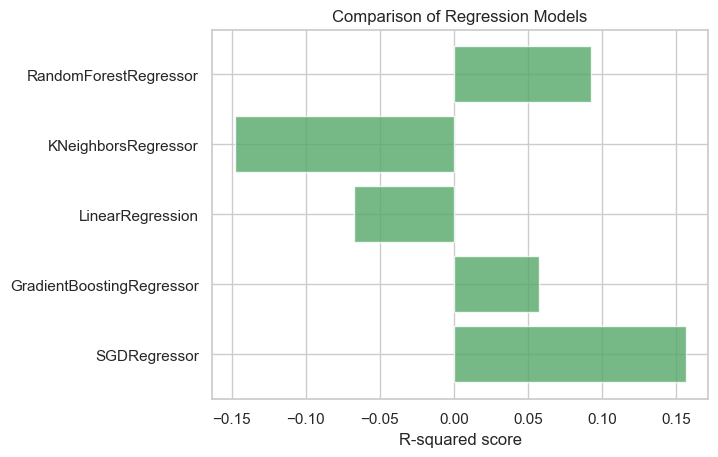

In [99]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('data/images/compare_models.png', bbox_inches = 'tight')

The **GradientBoostingRegressor** has the best R2 score of ~48% so we focus on refining this particular model.

In [100]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.057687


## 7. Parameter Tuning

To refine the GradientBoostingRegressor model, **GridSearchCV** function from scikit-learn is used to test out various permutations of parameters such as *n_estimators, max_depth, and loss*. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, we could select the best parameters from the listed hyperparameters.

In [101]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)
                                                    
# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]

tuned_parameters = [{'n_estimators': [100, 200, 300, 400],
                     'max_depth' : [2, 3, 4, 5],
                     'loss': ['squared_error', 'quantile', 'absolute_error', 'huber']}]
# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters, verbose = 1)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0.18554740069820677
GradientBoostingRegressor(loss='absolute_error', max_depth=5)


**Tuned Paramters**
- *n_estimators*: The number of boosting stages to perform.
- *max_depth*: maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
- *loss*: loss function to be optimized. ‘ls’ refers to least squares regression. ‘lad’ (least absolute deviation) is a highly robust loss function solely based on order information of the input variables. ‘huber’ is a combination of the two. 

The best estimator result from GridSearchCV was n_estimators=300, max_depth=4, loss = ls.

In [102]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.144738


**Parameter tuning didn't improve the R2 score.** This could mean that the model is overfitting the training data and can't generalize well on new data. For this reason we continue to use default parameters for GradientBoostingRegressor.

## 8. Model evaluation and result Discussion

First of al we could look at what features were most important in predicting hospital length-of-stay when using the gradient boosting regression model.

In [103]:
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
injury,0.143058
digestive,0.084095
circulatory,0.070389
respiratory,0.049329
endocrine,0.047118
nervous,0.039851
Surgical Intensive Care Unit (SICU),0.038968
infectious,0.038576
Cardiac Vascular Intensive Care Unit (CVICU),0.037424
skin,0.036534


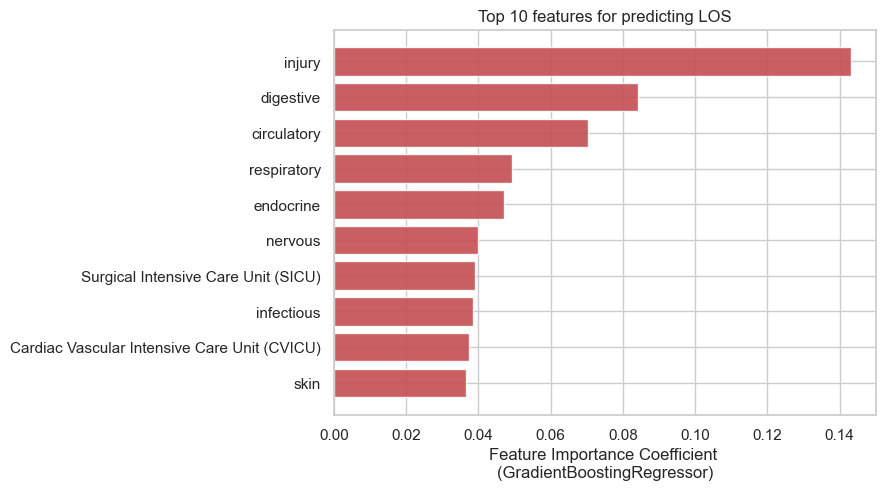

In [104]:
#Let's plot the top-10 feature importance
feature_imp.index[0:10].tolist()
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance_los_mimic4.png', bbox_inches = 'tight')

Diagnoses related to prenatal issues have the highest feature importance coefficient followed by ICU (of general type) admission, nervous and infectuous diagnosis. So we could say that, first of all, one of the results is that the *ICD-9 diagnoses categories* are by far the most important features between the features analyzed.

In previous metric section, we said that the RMSE would be used to compare the prediction model versus the industry-standard average and median LOS metrics.

In [105]:
# Hospital LOS metrics for later comparison
actual_mean_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].mean() 
actual_median_los = admits_patients_diag['los'].loc[admits_patients_diag['died_at_the_hospital'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

6.958476027397261
5.163541666666667


In [106]:
#y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_mean_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_mean_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 4.3302475341012014
Median Model days 4.8964583333333325
Average Model days 5.1289079147640795
Prediction Model RMS 1.1433914588839664
Median Model RMS 1.3170369885201514
Average Model RMS 1.242781174209339


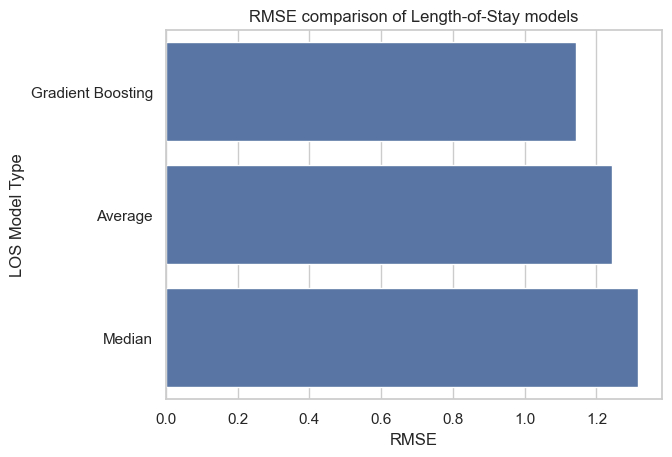

In [107]:
# RMSE plot
data = pd.DataFrame({'RMSE': [(ml_days_rms**0.5)/y_test_preds.shape[0], 
                             (avg_days_rms**0.5)/y_test_preds.shape[0],
                             (md_days_rms**0.5)/y_test_preds.shape[0]],
                     'LOS Model Type': ['Gradient Boosting', 'Average', 'Median'] })

fig, ax = plt.subplots()
ax = sns.barplot(x='RMSE', y='LOS Model Type', data=data)
ax.set_title('RMSE comparison of Length-of-Stay models')
ax.tick_params(top=False, left=False, right=False)

fig.savefig('images/rms_comparison_los_mimic4_01.png', bbox_inches = 'tight')

The gradient boosting model RMSE is better even if the percent difference in comparison to the constant average or median models, is not that high (as we can see from the graphic).

Another way to look at the model could be to plot the proportion of accurate predictions in the test set versus an allowed margin of error. Other studies qualify a LOS prediction as correct if it falls within a certain margin of error. Obviously, it follows that as the margin of error allowance increases, so should the proportion of accurate predictions for all models. The gradient boosting prediction model performs better than the other constant models across the margin of error range up to 50%.

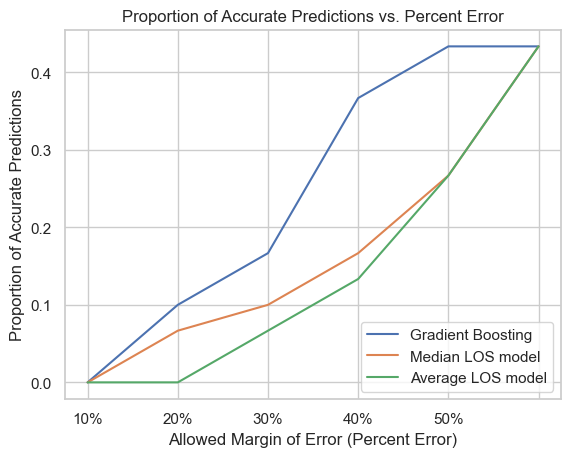

In [108]:
# Calculate Proportion of 'accurate' prediction as a function of allowed margin of error
reg_array = []
median_array = []
average_array = []

for i in list(range(6)):
    reg_count, median_count, average_count = 0, 0, 0
    
    for j in range(y_test_preds.shape[0]):
        # Percent Difference
        reg_model_res = (y_test_preds[j] - y_test[j])/y_test[j]
        median_model = (actual_median_los - y_test[j])/y_test[j]
        average_model = (actual_mean_los - y_test[j])/y_test[j]
        if abs(reg_model_res) < i/10:
            reg_count += 1
        if abs(median_model) < i/10:
            median_count += 1
        if abs(average_model) < i/10:
            average_count += 1
            
    reg_array.append((reg_count/y_test_preds.shape[0]))
    median_array.append((median_count/y_test_preds.shape[0]))
    average_array.append((average_count/y_test_preds.shape[0]))

# Plot proportion of 'accurate' prediction as a function of allowed margin of error  
fig, ax = plt.subplots()
ax.plot(reg_array, label='Gradient Boosting')
ax.plot(median_array, label='Median LOS model')
ax.plot(average_array, label='Average LOS model')
ax.set_title('Proportion of Accurate Predictions vs. Percent Error')
ax.set_xlabel('Allowed Margin of Error (Percent Error)')
ax.set_ylabel('Proportion of Accurate Predictions')
ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
ax.legend(loc='lower right');
ax.tick_params(top=False, right=False)
fig.savefig('images/rms_comparison_los_mimic4_02.png', bbox_inches = 'tight')

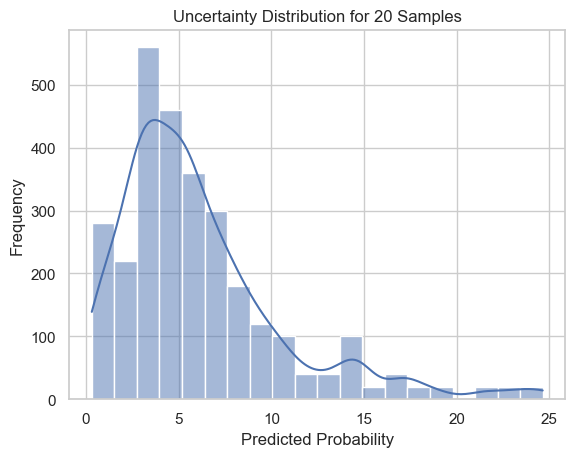

In [111]:
def predict_with_mc_dropout(model, x, num_samples=20):
    # model.train()  # ENABLE dropout
    preds = [model.predict(x) for _ in range(num_samples)]
    predictions = np.array(preds)
    mean_pred = np.mean(predictions, axis=0)
    var_pred = np.var(predictions, axis=0)
    return predictions, mean_pred, var_pred
def plot_uncertainty_distribution(predictions, label="Sample"):
    sns.histplot(predictions, bins=20, kde=True)
    plt.title(f"Uncertainty Distribution for 20 {label}s")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()
predictions, _, _ = predict_with_mc_dropout(reg_model_optimized, features, num_samples=20)
plot_uncertainty_distribution(predictions.flatten())

In [112]:
# Save features to a CSV file (efficient for tabular data)
features.to_csv('./data/features.csv', index=False)

# Save LOS as a numpy binary file (space-efficient and fast)
np.save('./data/los.npy', LOS)